## Assignment 1
### Name: Sourodeep Datta
### Roll Number: 21CS10064

In [1]:
# import all the necessary libraries here
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import graphviz

In [2]:
df = pd.read_csv('../../dataset/decision-tree.csv')
print(df.shape) 

(768, 9)


In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
y = df['Outcome']
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [5]:
df = df.drop(['Outcome'], axis = 1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


### Creating Train and Test Sets

In [6]:
train_df = df.sample(frac = 0.8, random_state = 218)
test_df = df.drop(train_df.index)

In [7]:
print(train_df.shape)
print(test_df.shape)

(614, 8)
(154, 8)


In [8]:
y_train = y[train_df.index]
y_test = y[test_df.index]

In [9]:
train_df.reset_index(drop = True, inplace=True)
test_df.reset_index(drop = True, inplace=True)
y_train.reset_index(drop = True, inplace=True)
y_test.reset_index(drop = True, inplace=True)

In [10]:
X_train = np.array(train_df)
X_test = np.array(test_df)

### Creating Decision Tree

In [11]:
class TreeNode:
    def __init__(self, is_leaf, label, feature_index, threshold, left, right, ID):
        self.is_leaf = is_leaf
        self.label = label
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.ID = ID

class DecisionTree:
    
    def __init__(self, X_test, y_test):
        self.root = None
        self.test_acc = {}
        self.X_test = X_test
        self.y_test = y_test
        self.total_ID = 0
    
    def count_nodes(self, node):
        if node.is_leaf:
            return 1
        return 1 + self.count_nodes(node.left) + self.count_nodes(node.right)

    def fit(self, X, y):
        self.root = self.build_tree(X, y)
        
    def entropy(self, y):
        unique_classes, counts = np.unique(y, return_counts = True)
        num_total = len(y)
        entropy = 0
        
        for i in range(len(unique_classes)):
            prob = counts[i]/num_total
            entropy += prob*np.log2(prob)
        
        return -entropy
        
    def information_gain(self, X, y, threshold):
        H = self.entropy(y)
        
        y_left = y[X <= threshold]
        y_right = y[X > threshold]
        
        H_left = self.entropy(y_left)
        H_right = self.entropy(y_right)
        
        num_left = len(y_left)
        num_right = len(y_right)
        num_total = num_left + num_right
        
        gain = H - (num_left/num_total)*H_left - (num_right/num_total)*H_right
        
        return gain
        
    def build_tree(self, X, y):
        
        num_samples, num_features = X.shape;
        unique_classes, counts = np.unique(y, return_counts = True)
        dominant_class = unique_classes[np.argmax(counts)]
        
        if num_samples < 10 or len(unique_classes) == 1:
            self.total_ID += 1
            return TreeNode(True, dominant_class, None, None, None, None, self.total_ID)
        
        best_gain = 0
        best_feature_index = None
        best_threshold = None
        
        for feature_index in range(num_features):
            X_curr = X[:, feature_index]
            
            thresholds = np.unique(X_curr)
            if len(thresholds) < 2:
                continue
            
            thresholds = (thresholds[1:] + thresholds[:-1]) / 2
            
            for threshold in thresholds:
                gain = self.information_gain(X_curr, y, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = threshold
                    
        if best_gain == 0:
            self.total_ID += 1
            return TreeNode(True, dominant_class, None, None, None, None, self.total_ID)
        
        X_left = X[X[:, best_feature_index] <= best_threshold]
        y_left = y[X[:, best_feature_index] <= best_threshold]
        X_right = X[X[:, best_feature_index] > best_threshold]
        y_right = y[X[:, best_feature_index] > best_threshold]
        
        left = self.build_tree(X_left, y_left)
        right = self.build_tree(X_right, y_right)
        
        self.total_ID += 1
        return TreeNode(False, None, best_feature_index, best_threshold, left, right, self.total_ID)
    
    def predict(self, X):
        return self.predict_helper(X, self.root)
    
    def predict_helper(self, X, node):
        if node.is_leaf:
            return node.label
        
        if X[node.feature_index] <= node.threshold:
            return self.predict_helper(X, node.left)
        else:
            return self.predict_helper(X, node.right)
        
    def multi_predict(self, X, node):
        return np.array([self.predict_helper(x, node) for x in X])
        
    def reduced_error_pruning(self, X_test, y_test):
        self.root = self.reduced_error_pruning_helper(self.root, X_test, y_test)
        total_nodes = self.count_nodes(self.root)
        total_accuracy = np.sum(self.multi_predict(self.X_test, self.root) == self.y_test)/len(self.y_test)
        self.test_acc[total_nodes] = total_accuracy
        
    def reduced_error_pruning_helper(self, node, X_test, y_test):
        if node.is_leaf:
            return node
        
        X_test_left = X_test[X_test[:, node.feature_index] <= node.threshold]
        X_test_left = X_test_left.reshape(-1, X_test.shape[1])
        y_test_left = y_test[X_test[:, node.feature_index] <= node.threshold]
        X_test_right = X_test[X_test[:, node.feature_index] > node.threshold]
        X_test_right = X_test_right.reshape(-1, X_test.shape[1])
        y_test_right = y_test[X_test[:, node.feature_index] > node.threshold]
        
        if len(y_test_left) == 0 or len(y_test_right) == 0:
            return node
        
        node.left = self.reduced_error_pruning_helper(node.left, X_test_left, y_test_left)
        node.right = self.reduced_error_pruning_helper(node.right, X_test_right, y_test_right)
        
        y_pred = self.multi_predict(X_test, node)
        accuracy = np.sum(y_pred == y_test)/len(y_test)
        
        max_label = np.argmax(np.unique(y_test, return_counts = True)[1])
        leaf_pred = np.array([max_label]*len(y_test))
        accuracy_leaf = np.sum(leaf_pred == y_test)/len(y_test)
        
        if accuracy_leaf > accuracy:
            total_nodes = self.count_nodes(self.root)
            total_accuracy = np.sum(self.multi_predict(self.X_test, self.root) == self.y_test)/len(self.y_test)
            self.test_acc[total_nodes] = total_accuracy
            
            return TreeNode(True, max_label, None, None, None, None, node.ID)
        
        return node
        

In [12]:
tree = DecisionTree(X_test, y_test)

In [13]:
tree.fit(X_train, y_train)
print(tree.count_nodes(tree.root))

137


### Pruning Decision Tree

In [14]:
tree.reduced_error_pruning(X_test, y_test)
print(tree.count_nodes(tree.root))

73


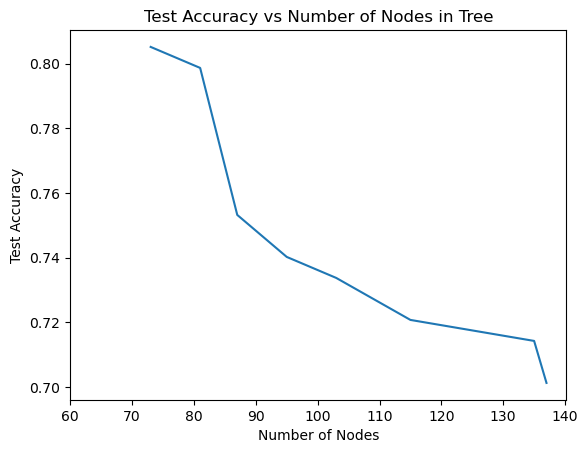

In [15]:
plt.plot(tree.test_acc.keys(), tree.test_acc.values())
plt.title('Test Accuracy vs Number of Nodes in Tree')
plt.xticks(np.arange(60, 150, 10))
plt.xlabel('Number of Nodes')
plt.ylabel('Test Accuracy')
plt.show()

### Creating Graph of Tree

In [153]:
dot = graphviz.Digraph(graph_attr={'size': '20,20', 'ranksep': '0.02', 'nodesep': '0.05'}, node_attr={'fontsize': '6', 'margin' : '0.005'}, edge_attr={'fontsize': '8', 'arrowsize': '0.5'})

def print_tree(node, dot):
    if node.is_leaf:
        dot.node(str(node), "ID " + str(node.ID) + "\n Classification -> " + str(node.label))
        return
    
    attr = df.columns[node.feature_index]
    dot.node(str(node), "ID " + str(node.ID) + "\n" + str(attr) + " <= " + str(node.threshold))
    print_tree(node.left, dot)
    print_tree(node.right, dot)
    dot.edge(str(node), str(node.left), label = "Yes")
    dot.edge(str(node), str(node.right), label = "No")

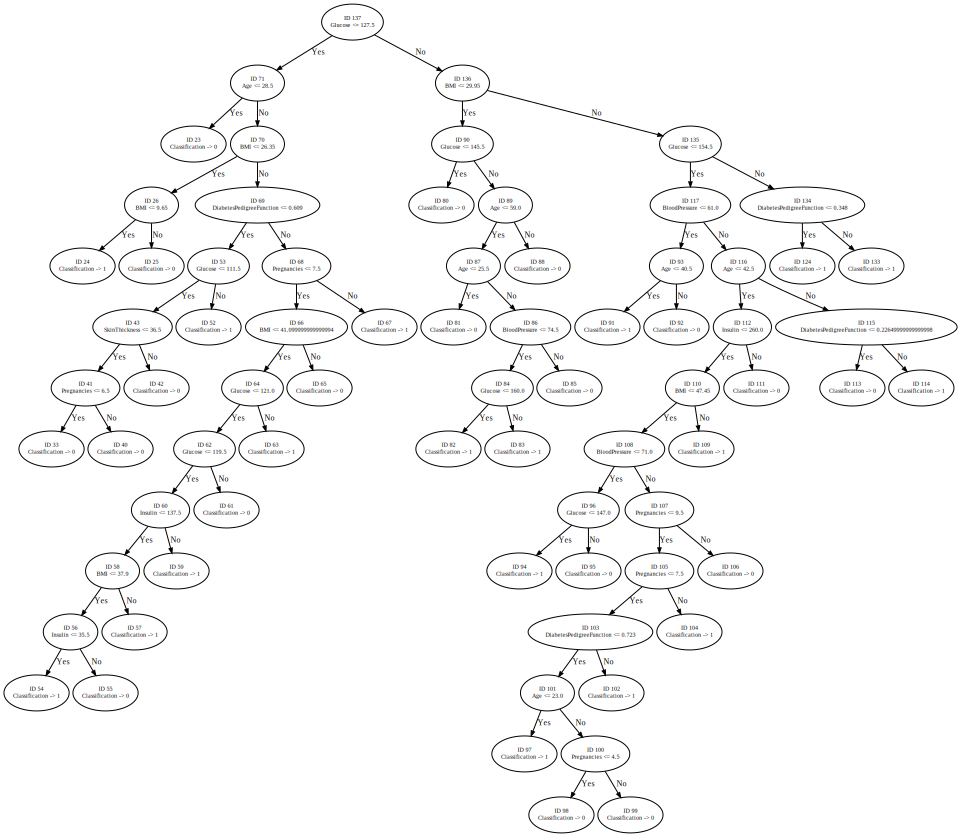

In [154]:
print_tree(tree.root, dot)
dot

### Calculating Metrics

In [150]:
def mean_macro_accuracy(y_pred, y_test):
    return np.sum(y_pred == y_test)/len(y_pred)

def mean_macro_precision(y_pred, y_test):
    unique_classes = np.unique(y_test)
    precision = 0
    
    for i in range(len(unique_classes)):
        class_indices = y_pred == unique_classes[i]
        precision += np.sum(y_pred[class_indices] == y_test[class_indices])/len(y_pred[class_indices])
    
    return precision/len(unique_classes)

def mean_macro_recall(y_pred, y_test):
    unique_classes = np.unique(y_test)
    recall = 0
    
    for i in range(len(unique_classes)):
        class_indices = y_test == unique_classes[i]
        recall += np.sum(y_pred[class_indices] == y_test[class_indices])/len(y_test[class_indices])
    
    return recall/len(unique_classes)

In [151]:
y_pred = tree.multi_predict(X_test, tree.root)

In [152]:
print('Mean Macro Accuracy:', mean_macro_accuracy(y_pred, y_test))
print('Mean Macro Precision:', mean_macro_precision(y_pred, y_test))
print('Mean Macro Recall:', mean_macro_recall(y_pred, y_test))

Mean Macro Accuracy: 0.8051948051948052
Mean Macro Precision: 0.7887166075098075
Mean Macro Recall: 0.7838383838383838
